Author: JSzablanowski


# Travel Stack Exchange data analysis 
![Python](https://cdn.sstatic.net/Sites/travel/Img/logo.svg)



In [19]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.interpolate import interp1d

pd.set_option("display.notebook_repr_html", False)  # disable "rich" output
plt.style.use("seaborn")  # plot style

sns.set_palette([  # the "R4" palette
    "#000000", "#DF536B", "#61D04F", "#2297E6",
    "#28E2E5", "#CD0BBC", "#F5C710", "#999999"
])

plt.rcParams.update({
    "font.size":         11,
    "font.family":       "sans-serif",
    "font.sans-serif":   ["Alegreya Sans", "Alegreya"],
    "figure.autolayout": True,
    "figure.dpi":        300,
    "figure.figsize":    (7, 4.5),  # default is [8.0, 5.5],
})

### Load data

In [2]:
posts = pd.read_xml("travel-data/raw/Posts.xml", parser = 'etree')
tags = pd.read_xml("travel-data/raw/Tags.xml", parser = 'etree')

### Number of new posts in a given interval

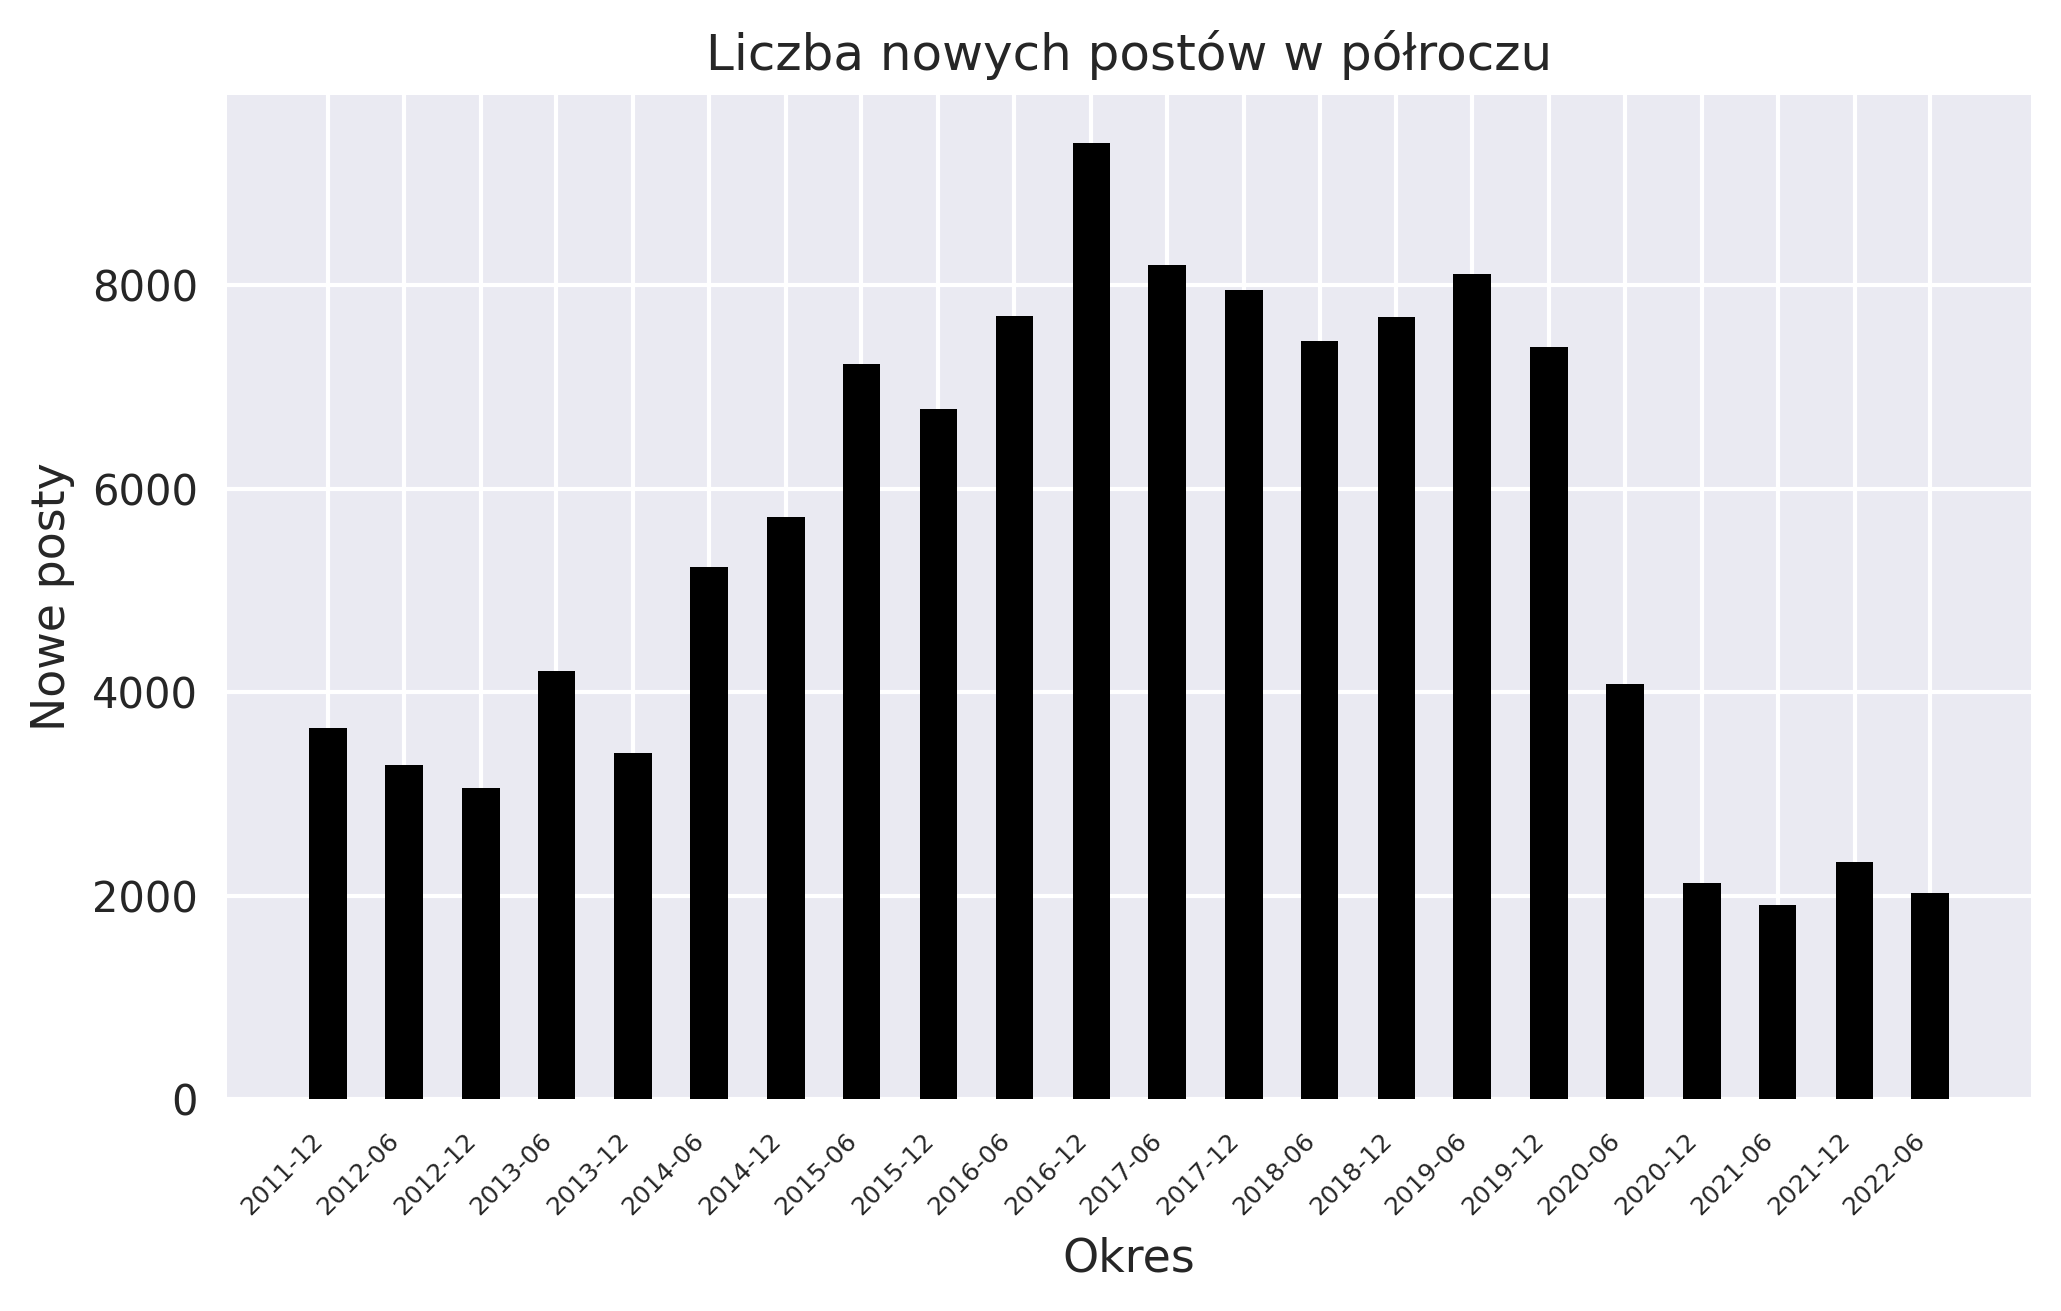

In [20]:
posts['CreationDateMonth'] = [datetime(int(date[0:4]), int(date[5:7]), 1) for date in posts.CreationDate]

grouped = posts.groupby(by=posts.CreationDateMonth)['Id'].count().reset_index()

grouped.rename(columns = {'CreationDateMonth':'Month', 'Id':'Count'}, inplace = True)
grouped.sort_values(by = "Month", ascending=True, inplace=True)

interval = grouped.resample('6m', on='Month').Count.sum()[1:].reset_index()

plt.bar(interval['Month'], interval['Count'], width = 90)
plt.xticks(interval['Month'], interval['Count'], rotation=45, fontsize='6', horizontalalignment='right')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.title('Liczba nowych postów w półroczu')
plt.xlabel('Okres')
plt.ylabel('Nowe posty')
plt.show()

In [4]:
tags[ tags.Count > 500 ].sort_values(by=["Count"], ascending = False)

        Id                  TagName  Count  ExcerptPostId  WikiPostId
15      20                    visas   9679          311.0       310.0
9       14                      usa   5348          158.0       157.0
131    197                       uk   4789          413.0       412.0
34      46               air-travel   4620          255.0       254.0
132    199  customs-and-immigration   3641          541.0       540.0
165    270                 schengen   3408         1126.0      1125.0
205    353                  transit   2152         1195.0      1194.0
186    313                passports   1778         1221.0      1220.0
493   1097          indian-citizens   1722         5021.0      5020.0
22      29                   trains   1554          337.0       336.0
178    299                   canada   1513         1790.0      1789.0
40      53                  luggage   1379          325.0       324.0
190    323                  tickets   1294         2224.0      2223.0
19      26     inter

### Analyze, which country lost most of its popularity as a travel destination

In [5]:
# get top 6 countries from tags
countries = ['usa', 'uk',  'germany', 'france', 'japan', 'italy']

# covid start date 
covid_start_date = datetime(2020, 3, 11)
covid_first_case = datetime(2019, 11, 17)

In [6]:
def extractCountry(tags):
    if pd.isna(tags):
        return ""
    for country in countries:
        if country in tags:
            return country



posts["Country"] = posts["Tags"].astype("string").apply(extractCountry)
postsByCountry = posts[(pd.isna(posts.Country) == False) & (posts.Country != "")]

### Draw plots

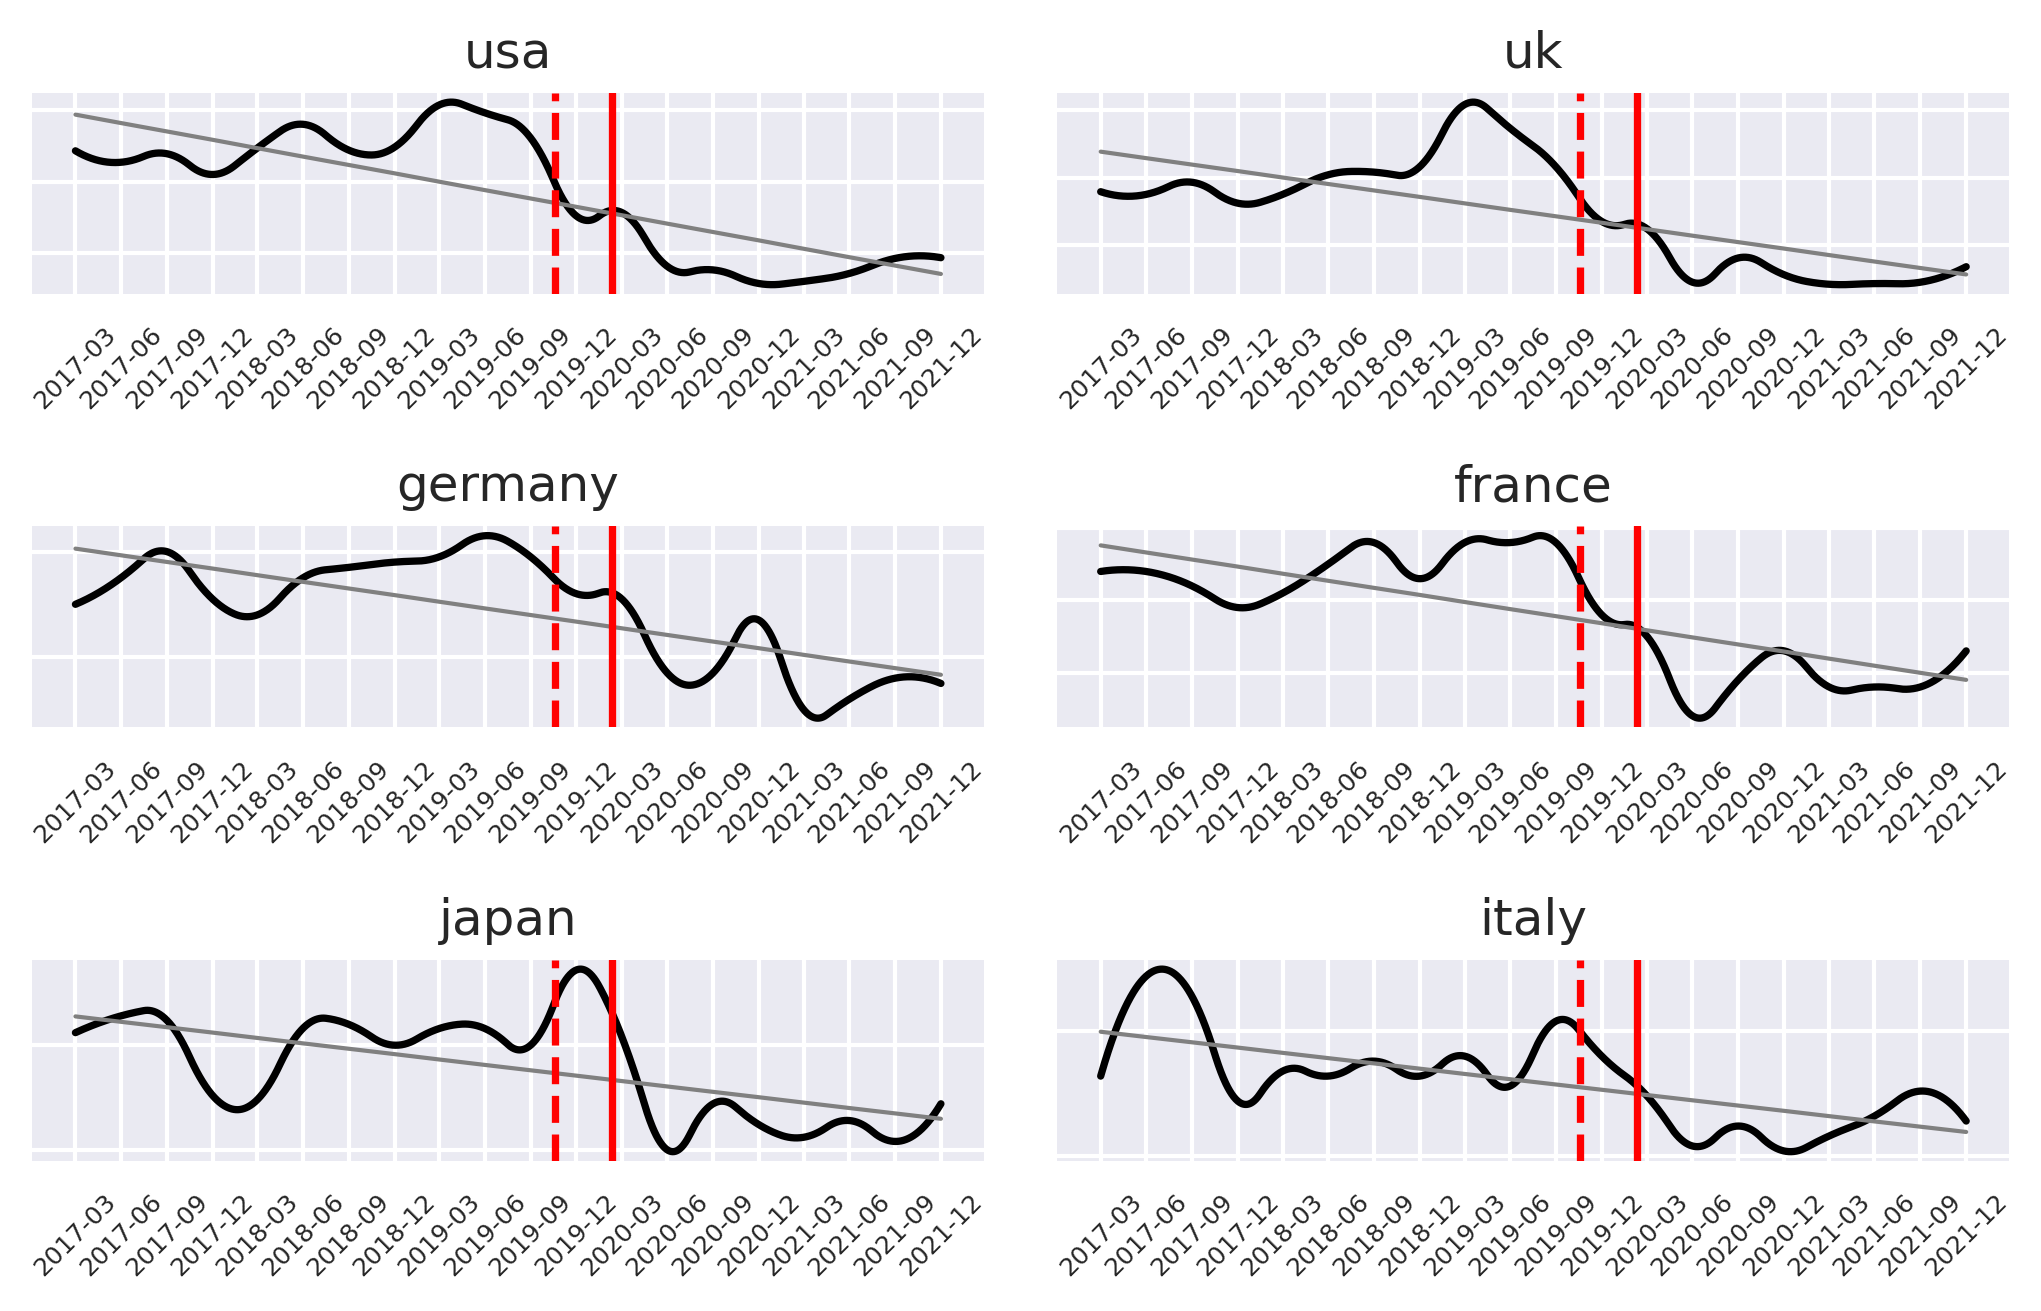

In [21]:
fig = plt.figure(1)
pd.options.mode.chained_assignment = None  # default='warn'
most_decreasing_trend_dict = {}


for i in range(len(countries)):
    ax = plt.subplot(3,2,i + 1)
    p = postsByCountry[postsByCountry.Country == countries[i]]
    p['CreationDateMonth'] = [datetime(int(date[0:4]), int(date[5:7]), int(date[8:10])) for date in p.CreationDate]

    grouped = p.groupby(by=p.CreationDateMonth)['Id'].count().reset_index()

    grouped.rename(columns = {'CreationDateMonth':'Month', 'Id':'Count'}, inplace = True)
    grouped.sort_values(by = "Month", ascending=True, inplace=True)

    interval = grouped.resample('3m', on='Month').Count.sum()[1:]
    trimmed = interval[interval.index.to_series().between(covid_start_date + relativedelta(months=-36), covid_start_date + relativedelta(months=24))]
    interval = interval.reindex(pd.date_range(start=trimmed.index.min(), end=trimmed.index.max(), freq='1d'))

    interpolated = interval.interpolate(method='quadratic')

    plt.plot(interpolated, label="nowe posty w kwartale")
    ab = np.polyfit(np.arange(len(trimmed)), trimmed.to_numpy(), deg=1) 
    linex = np.arange(len(trimmed))
    line_fun = lambda x: ab[0]*x + ab[1]
    plt.plot(trimmed.index, line_fun(linex), color='grey', linewidth=1, label="linia trendu")

    most_decreasing_trend_dict[countries[i]] = ab[0] 

    ax.yaxis.set_ticklabels([])
    ax.set_xticks(trimmed.index)
    ax.set_xticklabels(trimmed.index, rotation=45, fontsize='6')
    ax.axvline(x=covid_start_date, color='red', label="początek pandemii")
    ax.axvline(x=covid_first_case, color='red', linestyle = '--', label="pierwszy przypadek COVID-19")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.set_title(countries[i])

plt.show()
most_decreasing_trend = pd.Series(most_decreasing_trend_dict)

### Perform Mann-Kendall Trend Test

In [8]:
import pymannkendall as mk

most_decreasing_trend_mk_dict = {}

for i in range(len(countries)):
    p = postsByCountry[postsByCountry.Country == countries[i]]
    p['CreationDateMonth'] = [datetime(int(date[0:4]), int(date[5:7]), int(date[8:10])) for date in p.CreationDate]

    grouped = p.groupby(by=p.CreationDateMonth)['Id'].count().reset_index()

    grouped.rename(columns = {'CreationDateMonth':'Month', 'Id':'Count'}, inplace = True)
    grouped.sort_values(by = "Month", ascending=True, inplace=True)

    interval = grouped.resample('3m', on='Month').Count.sum()[1:]
    trimmed = interval[interval.index.to_series().between(covid_start_date + relativedelta(months=-36), covid_start_date + relativedelta(months=24))]
    test_results = mk.original_test(trimmed)
    most_decreasing_trend_mk_dict[countries[i]] = (test_results.slope, test_results.p, test_results.trend)

most_decreasing_trend_mk = pd.Series(most_decreasing_trend_mk_dict)

In [9]:
most_decreasing_trend.sort_values()

usa       -11.688722
uk         -9.565414
japan      -1.287970
germany    -1.258647
italy      -1.056391
france     -0.980451
dtype: float64

In [10]:
most_decreasing_trend_mk.sort_values()

usa                (-11.1, 0.017863627708934793, decreasing)
uk         (-8.697916666666668, 0.011255669635285015, dec...
japan      (-1.188235294117647, 0.004187898153615421, dec...
germany    (-1.1699346405228759, 0.010213630825139708, de...
italy      (-0.9615384615384616, 0.006944080501828154, de...
france     (-0.898989898989899, 0.00603056360323273, decr...
dtype: object

### Number of new users in the service

In [17]:
users = pd.read_xml("travel-data/raw/Users.xml", parser = 'etree')
posts = pd.read_xml("travel-data/raw/Posts.xml", parser = 'etree')
comments = pd.read_xml("travel-data/raw/Comments.xml", parser = 'etree')
votes = pd.read_xml("travel-data/raw/Votes.xml", parser = 'etree')

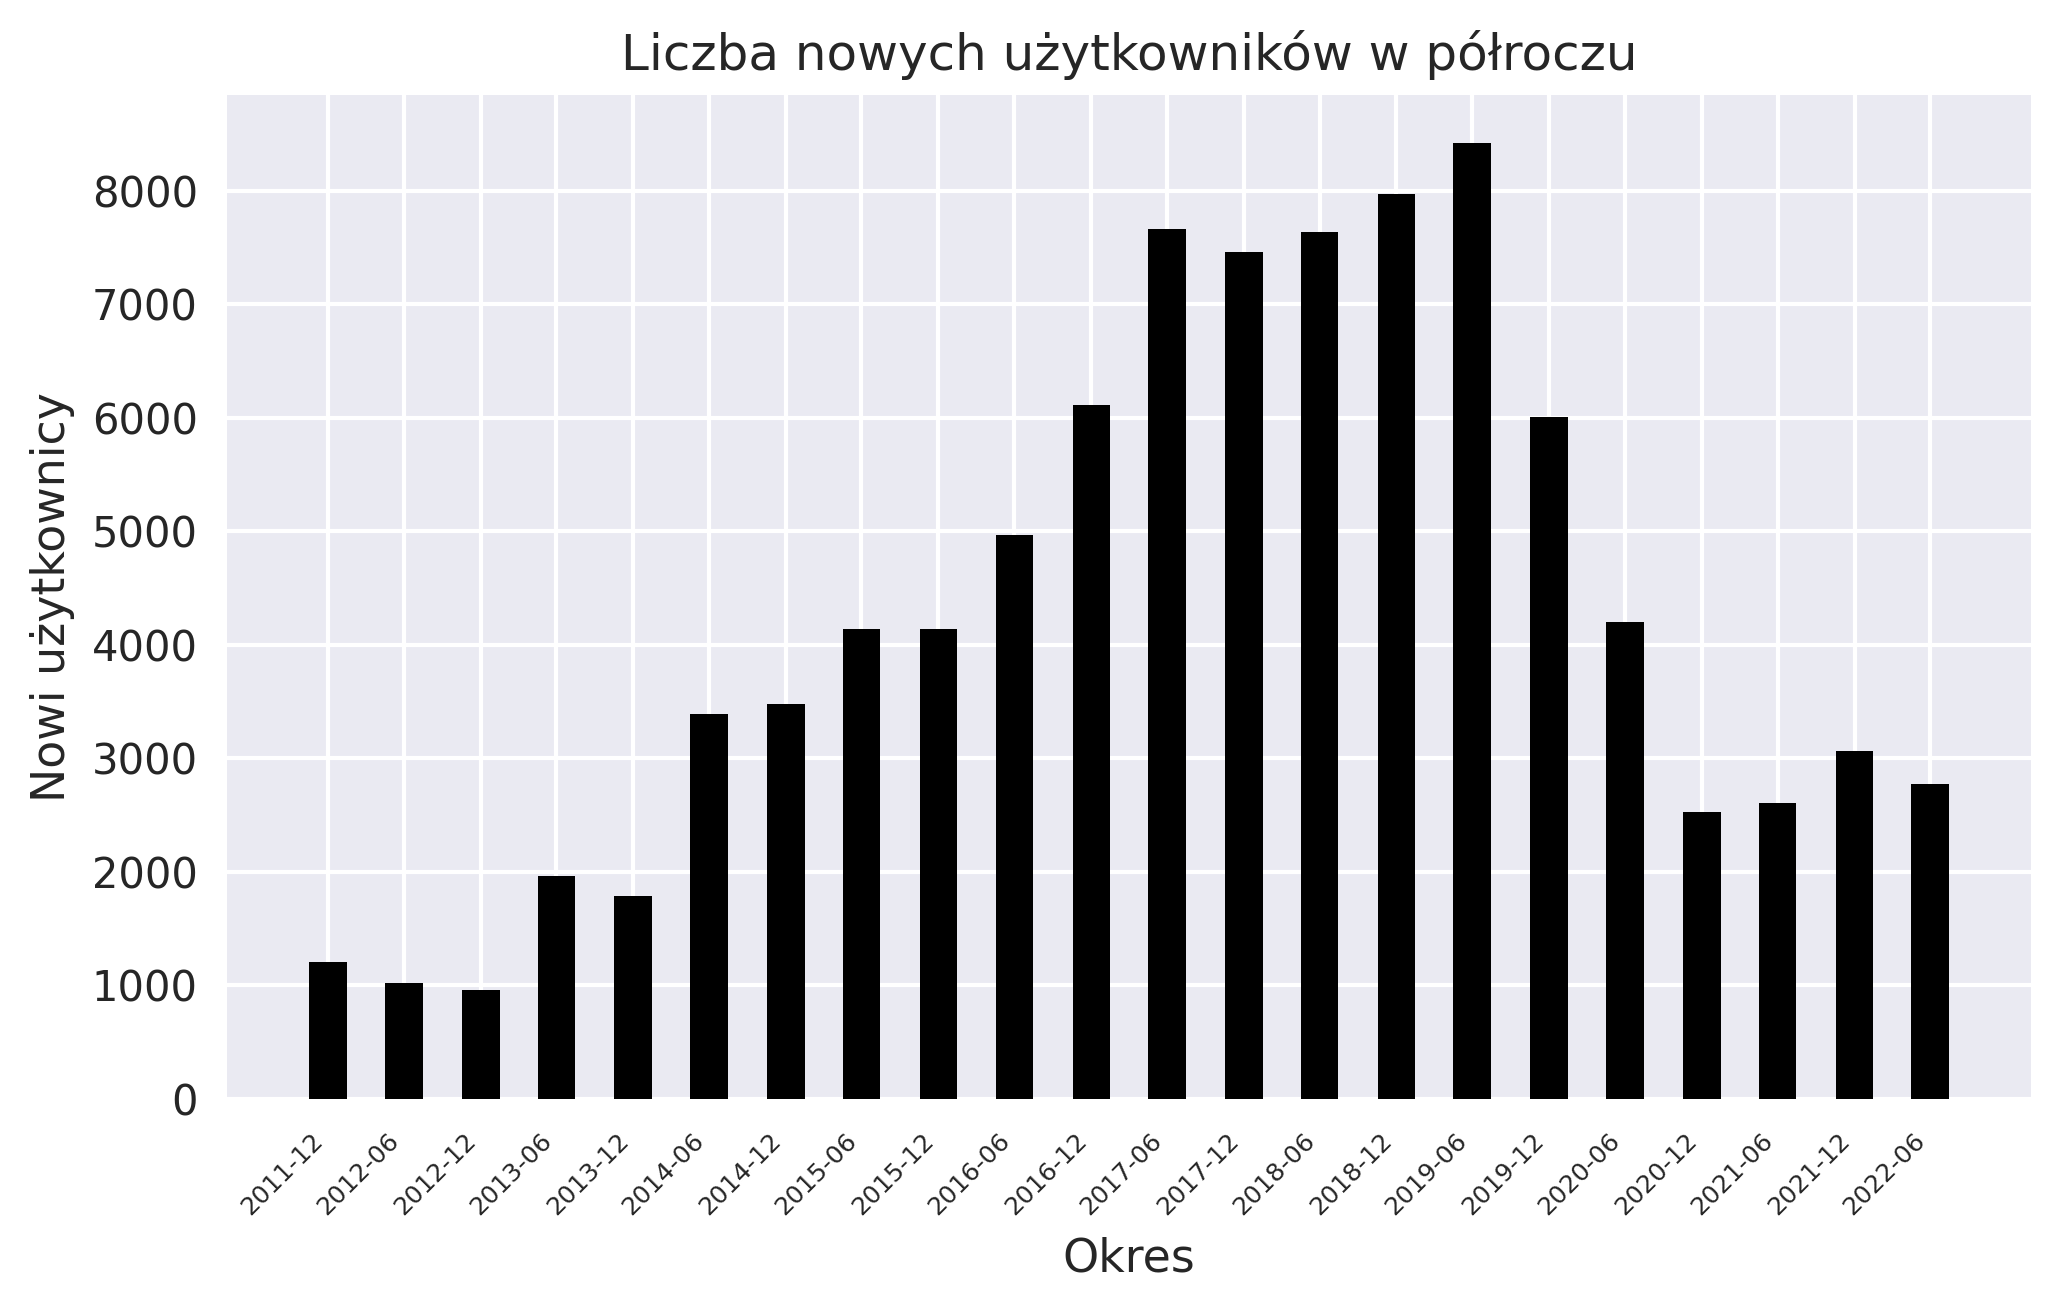

In [22]:
users['CreationDateMonth'] = [datetime(int(date[0:4]), int(date[5:7]), int(date[8:10])) for date in users.CreationDate]

grouped = users.groupby(by=users.CreationDateMonth)['Id'].count().reset_index()

grouped.rename(columns = {'CreationDateMonth':'Month', 'Id':'Count'}, inplace = True)
grouped.sort_values(by = "Month", ascending=True, inplace=True)

counts = grouped.resample('6m', on='Month').Count.sum()
interval = counts[1:len(counts)].reset_index()

plt.bar(interval['Month'], interval['Count'], width = 90)
plt.xticks(interval['Month'], interval['Count'], rotation=45, fontsize='6', horizontalalignment='right')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.title('Liczba nowych użytkowników w półroczu')
plt.xlabel('Okres')
plt.ylabel('Nowi użytkownicy')
plt.show()

### Number of votes depending on the the occurrence of 'covid' phrase

In [13]:
def extractCovid(body):
    if (pd.isna(body)):
        return False
    if ('covid' in body.lower()):
        return True
    else:
        return False


posts["Covid"] = posts["Body"].astype("string").apply(extractCovid)

#### Votes - no-COVID vs COVID

/tmp/ipykernel_3975/1213062622.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  posts_ = posts[pd.isna(posts.ParentId)][posts.CreationDate > '2019-10-01']


Wszystkie: 5.947962603633798
Covid:  6.8706070287539935


Text(0, 0.5, 'Liczba głosów')

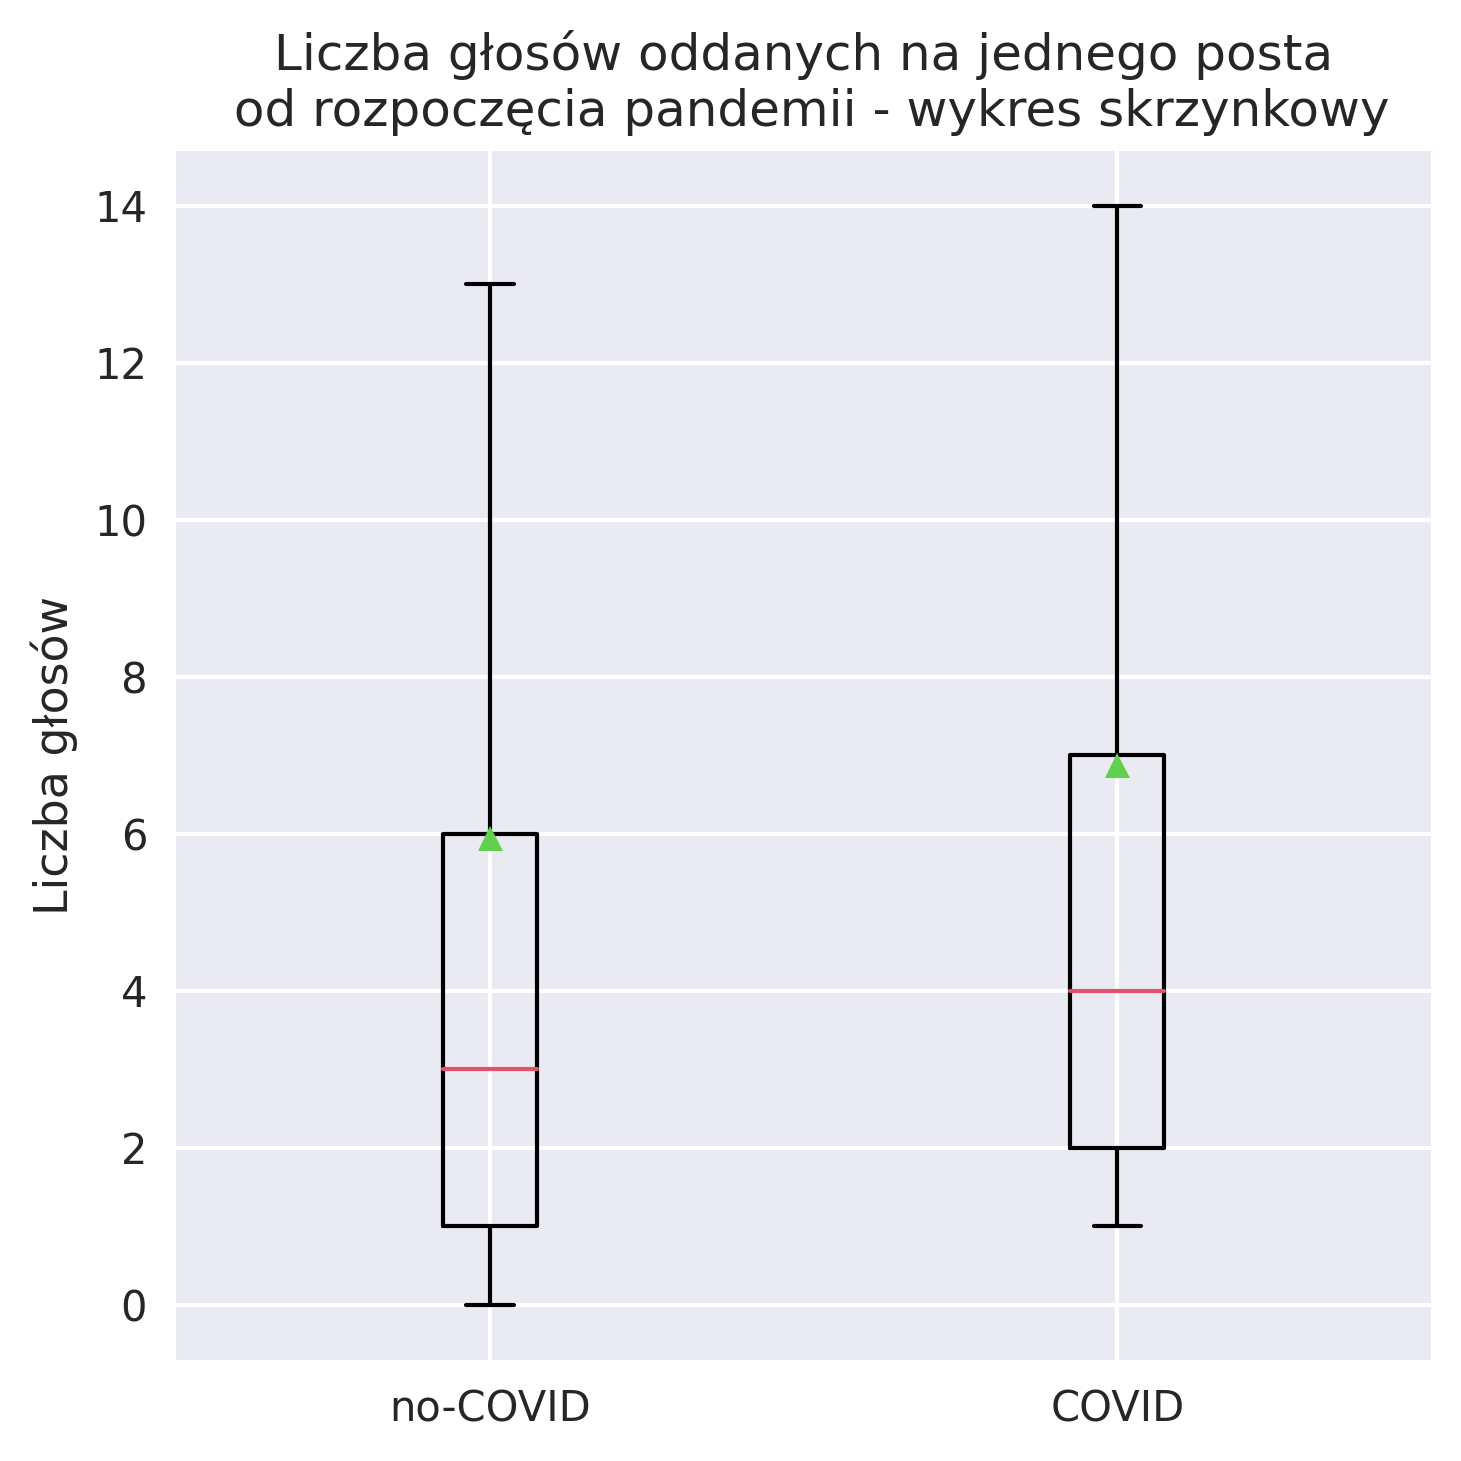

In [23]:
posts_ = posts[pd.isna(posts.ParentId)][posts.CreationDate > '2019-10-01']

merged = posts_[posts_.Covid == False].loc[:, ('Id', 'Body',  'Covid')].merge(votes, left_on='Id', right_on='PostId', how='left')

v = merged.groupby(by=merged.Id_x)['Body'].count().reset_index()
v.rename(columns = {'Id_x':'PostId', 'Body':'Count'}, inplace = True)

print("Wszystkie:",v.Count.mean())

merged_cov = posts_[posts_.Covid == True].loc[:, ('Id', 'Body', 'Covid')].merge(votes, left_on='Id', right_on='PostId', how='left')
votes_cov = merged_cov.groupby(by=merged.Id_x)['Body'].count().reset_index()
votes_cov.rename(columns = {'Id_x':'PostId', 'Body':'Count'}, inplace = True)

print("Covid: ", votes_cov.Count.mean())

d = {"no-COVID": v.Count, "COVID": votes_cov.Count}

fig, ax = plt.subplots(figsize=(5,5))
ax.boxplot(d.values(), \
    showfliers=False, vert=True, showmeans=True,
    meanprops={"color":"red", "ls":"-"})
ax.set_xticklabels(['no-COVID', 'COVID'])
ax.set_title('Liczba głosów oddanych na jednego posta\n od rozpoczęcia pandemii - wykres skrzynkowy')
ax.set_ylabel('Liczba głosów')